In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.cross_validation import train_test_split

%matplotlib inline

/Users/aleksejfilippov/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [3]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [4]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [5]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X = train_data['data']
Y = train_data['target']
Y_oh = np.array(list(map(lambda x : encoder.transform(x), Y)))

mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / (std + 0.0001)
X_test_fin = (X - mean) / (std + 0.0001)

X_train, X_test, Y_train, Y_test, Yf_train, Yf_test = train_test_split(X, Y_oh, Y, test_size=0.33, stratify=Y)

X_test_fin = test_data['data']

In [6]:
print(X_train.shape)
print(X_test_fin.shape)

(35175, 784)
(17500, 784)


In [7]:
# Определение слоев сети
# class Dense:
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.001):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2/(out_size + in_size))
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W) 
        # рассчитываем градиенты от регуляризатора
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.db = self.db - lr * self.db
        # возвращаем dx для продолжения алгоритма
        return self.dx

In [8]:
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -np.sum(y_true * np.log(y_hat))
    
    def backward(self, dz, lr=0.00001):
        return dz * -1. * self.y_true / self.y_hat

In [9]:
class Max:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz

In [10]:
class Softmax:
    
    def forward(self, x):
        self.x = x
        exps = np.exp(x)
        return exps / np.sum(exps)
    
    def backward(self, dz, lr=0.001):
        z = self.forward(self.x)
        self.lp = (np.eye(z.shape[0], z.shape[0]) - z).T
        self.lp2 = z * self.lp
        return np.dot(dz, self.lp2)

In [64]:
class Dropout:
    def __init__(self, p = 0.5):
        self.p = p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
        
    def set_p(self, p):
        self.p = p
    
    def forward(self, x):
        if not self.train:
            self.mask = np.ones(*x.shape)
            return x
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p)
        return x * self.mask
        
    def backward(self, dz, lr=0.001):
        return dz * self.mask

In [ ]:
class MnistNet1:
    def set_rlambda(self, rlambda = 0.0):
        self.rlambda = rlambda
    
    def __init__(self, rlambda = self.rlambda):
        self.d1 = Dense(784, 220, self.rlambda)
        self.m1 = Max()
        self.dr2 = Dropout(0.3)
        self.d2 = Dense(220, 10, self.rlambda)
        self.s = Softmax()
    
    def forward(self, x):
        net = self.d1.forward(x)
        net = self.m1.forward(net)
        net = self.dr2.forward(net)
        net = self.d2.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr = 0.001):
        dz = self.s.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.dr2.backward(dz, lr)
        dz = self.m1.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        return dz

In [67]:
net = MnistNet1(0.001)
loss = CrossEntropy()
net.dr2.set_train(True)
net.dr2.set_p(0.5)
lr = 0.001
L_train = []
L_test = []
accuracy_test = []
accuracy_train = []
for iter in range(100):
    L_acc = 0.
    sh = list(range(X_train.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh)
    for i in range(X_train.shape[0]):
        x = X_train[sh[i]]
        y = Y_train[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_acc += L 
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    L_acc /= Y_train.shape[0]
    L_train.append(L_acc)
    net.dr2.set_train(False)
    L_e_acc = 0.
    for i in range(X_test.shape[0]):
        x = X_test[i]
        y = Y_test[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_e_acc += L
    L_e_acc /= Y_test.shape[0]
    L_test.append(L_e_acc)
    net.dr2.set_train(True)
    print("{} iter loss. Train : {} . Test : {}".format(iter, L_acc, L_e_acc))


0 iter loss. Train : 0.4989127013568638 . Test : 0.25729520452182647
1 iter loss. Train : 0.2786643247603829 . Test : 0.21587876741247225
2 iter loss. Train : 0.23086243764287062 . Test : 0.20131416478584063
3 iter loss. Train : 0.2048049960013973 . Test : 0.1786169034575989
4 iter loss. Train : 0.1806705114191323 . Test : 0.17272360803267162
5 iter loss. Train : 0.1668810978627045 . Test : 0.16570971121680214
6 iter loss. Train : 0.15293247058570178 . Test : 0.156955436798562
7 iter loss. Train : 0.14102029562373308 . Test : 0.15643656727253735
8 iter loss. Train : 0.13097681946957151 . Test : 0.15120017913538392
9 iter loss. Train : 0.12226140458455788 . Test : 0.1472998294466532
10 iter loss. Train : 0.12015112953460912 . Test : 0.14299017357912683
11 iter loss. Train : 0.11188702004574025 . Test : 0.14260842746919997
12 iter loss. Train : 0.10941669559636516 . Test : 0.13921793075556058
13 iter loss. Train : 0.10748764871588566 . Test : 0.14075211670534163
14 iter loss. Train : 0.1

In [68]:
compute_acc(X_test, Yf_test, net)

0.9583838383838383

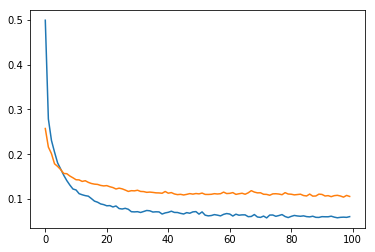

In [69]:
plt.plot(L_train, label='train')
plt.plot(L_test, label='test')

In [70]:
# формируем сабмишшен и заливаем его на kaggle
net.dr2.set_train(False)

make_submission(X_test_fin, net)

/Users/aleksejfilippov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
